### Import libraries

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical


tf.keras.backend.clear_session()

### Loading Dataset

#### Lower Back Pain Symptoms Dataset

Source: https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

In [ ]:
spine_data = pd.read_csv('dataset/Dataset_spine.csv', 
                         skiprows=1,
                         names=['pelvic_incidence',
                                'pelvic tilt',
                                'lumbar_lordosis_angle',
                                'sacral_slope',
                                'pelvic_radius',
                                'degree_spondylolisthesis',
                                'pelvic_slope',
                                'direct_tilt',
                                'thoracic_slope',
                                'cervical_tilt',
                                'sacrum_angle',
                                'scoliosis_slope',
                                'class_att'])

spine_data = spine_data.sample(frac=1).reset_index(drop=True)

In [ ]:
spine_data.head().T

In [ ]:
spine_data.shape

In [ ]:
spine_data.columns

In [ ]:
spine_data['class_att'].unique()

In [ ]:
spine_data.describe().transpose()

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot('class_att', data = spine_data)

plt.xlabel('class_att', fontsize = 20)
plt.ylabel('count', fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot('class_att', 'pelvic_incidence', data = spine_data)

plt.xlabel('class_att', fontsize = 20)
plt.ylabel('pelvic_incidence', fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot('class_att', 'lumbar_lordosis_angle', data = spine_data)

plt.xlabel('class_att', fontsize = 20)
plt.ylabel('lumbar_lordosis_angle', fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot('class_att', 'pelvic_radius', data = spine_data)

plt.xlabel('class_att', fontsize = 20)
plt.ylabel('pelvic_radius', fontsize = 20)

plt.show()

### Replacing string values with integers in target column

In [ ]:
class_att = {'Abnormal':0, 'Normal':1}

spine_data['class_att'].replace(class_att, inplace=True)

spine_data[['class_att']].sample(10)

In [ ]:
features = spine_data.drop('class_att', axis=1)

target = spine_data[['class_att']]

In [ ]:
features.sample(5).T

In [ ]:
target.sample(5)

In [ ]:
standardScaler = StandardScaler()

scaled_features = pd.DataFrame(standardScaler.fit_transform(features), 
                               columns=features.columns,
                               index=features.index)

scaled_features.describe().T

In [ ]:
processed_data = pd.concat([scaled_features, target], axis=1,
                            sort=False)
processed_data.head()

In [ ]:
processed_data.to_csv('dataset/spine_final_processed.csv')

### Splitting dataset into training and testing

In [2]:
df = pd.read_csv('dataset/spine_final_processed.csv')
scaled_features = df.drop('class_att', axis=1)
target = df.class_att

In [3]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    target, 
                                                    test_size=0.20,
                                                    random_state=10)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15,
                                                  random_state=10)

In [5]:
#class_weights = compute_class_weight(class_weight='balanced',  
#                                     classes=np.unique(y_train), 
#                                     y=y_train)
#model_class_weights = {}
#for e , weight in enumerate(class_weights):
#    model_class_weights[e] = weight

In [6]:
class SpineClassificationModel(Model):
    def __init__(self, input_shape):
        super(SpineClassificationModel, self).__init__()
        self.d0 = layers.Dense(128, activation = 'relu', input_shape = [input_shape])
        self.d1 = layers.Dense(64, activation = 'relu')
        self.d2 = layers.Dense(1, activation = 'sigmoid')
        self.num_epochs = 100

    def call(self, x):
        x = self.d0(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

    def plot_result(self, y_test, y_pred, training_history):
        dict_key = list(training_history.history.keys())
        
        train_acc = training_history.history['accuracy']
        train_loss = training_history.history['loss']
        precision = training_history.history[dict_key[2]]
        recall = training_history.history[dict_key[3]]
        epochs_range = range(self.num_epochs)

        print(f"Accuracy/Score: {accuracy_score(y_test, y_pred)}")
        print(f"Precision = {precision_score(y_test, y_pred)}\n")
        print("Classification Report:\n")
        print(classification_report(y_test, y_pred, digits=4))
         
        print('\n ploting graphs:')
        self.plot_grapghs(epochs_range, train_acc, train_loss, precision, recall)
        
        print("Confusion Matrix: ")
        self.confusion_matrix(y_test, y_pred)

        print('ROC: ')
        self.roc(y_test, y_pred)
    
    def plot_grapghs(self, epochs_range, train_acc, train_loss, precision, recall):
        plt.figure(figsize=(14, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_acc, label='Training Accuracy')
        plt.plot(epochs_range, train_loss, label='Training Loss')
        plt.title('Accuracy and Loss')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, precision, label='Precision')
        plt.plot(epochs_range, recall, label='Recall')
        plt.title('Precision and Recall')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    def confusion_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def roc(self, y_test, y_pred):
        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Ann_model(area = {round(logit_roc_auc,2)})")
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()

    def save_model(self, model, path):
        model.save(path)

    def save_model_as_json(self, model, model_path):
        model_json = model.to_json()
        with open(model_path, 'w') as outfile: 
            outfile.write(model_json) 

    def save_weight(self, model, weights_path):
        model.save_weights(weights_path)

    def load_model(self, model_path):
        model = None
        with open(model_path, 'r') as infile: 
            model_json = json.load(infile)
            model = tf.keras.models.model_from_json(json.dumps(model_json))
        return model

    def load_wights(self, model, weights_path):
        model.load_weights(weights_path)

    

In [7]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, 
                                                    y_train.values))
dataset_train = dataset_train.batch(16)
dataset_train.shuffle(128)

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 13), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
dataset_val = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
dataset_val = dataset_val.batch(16)

In [9]:
model = SpineClassificationModel(X_train.shape[1])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 
                        tf.keras.metrics.Precision(0.5),
                        tf.keras.metrics.Recall(0.5),])

In [27]:
training_history = model.fit(dataset_train, 
                             epochs=model.num_epochs, 
                             validation_data=dataset_val)

Epoch 1/100
14/14 [==============================] - 0s 18ms/step - loss: 0.2379 - accuracy: 0.9000 - precision: 0.8462 - recall: 0.8333 - val_loss: 0.9957 - val_accuracy: 0.7105 - val_precision: 0.5333 - val_recall: 0.6667
Epoch 2/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1660 - accuracy: 0.9238 - precision: 0.9167 - recall: 0.8333 - val_loss: 1.0221 - val_accuracy: 0.6842 - val_precision: 0.5000 - val_recall: 0.5833
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 0.2315 - accuracy: 0.8905 - precision: 0.8308 - recall: 0.8182 - val_loss: 1.0829 - val_accuracy: 0.6842 - val_precision: 0.5000 - val_recall: 0.6667
Epoch 4/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1978 - accuracy: 0.9190 - precision: 0.9016 - recall: 0.8333 - val_loss: 1.0736 - val_accuracy: 0.6842 - val_precision: 0.5000 - val_recall: 0.5833
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.2311 - accuracy: 0.8952 - pre

In [28]:
score = model.evaluate(X_test, y_test)
score_df = pd.Series(score, index = model.metrics_names)
score_df

2/2 [==============================] - 0s 10ms/step - loss: 0.4525 - accuracy: 0.8065 - precision: 0.7778 - recall: 0.6364


loss         0.452540
accuracy     0.806452
precision    0.777778
recall       0.636364
dtype: float64

In [29]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>=0.5, 1, 0)

2/2 [==============================] - 0s 3ms/step


Accuracy/Score: 0.8064516129032258
Precision = 0.7777777777777778

Classification Report:

              precision    recall  f1-score   support

           0     0.8182    0.9000    0.8571        40
           1     0.7778    0.6364    0.7000        22

    accuracy                         0.8065        62
   macro avg     0.7980    0.7682    0.7786        62
weighted avg     0.8038    0.8065    0.8014        62


 ploting graphs:


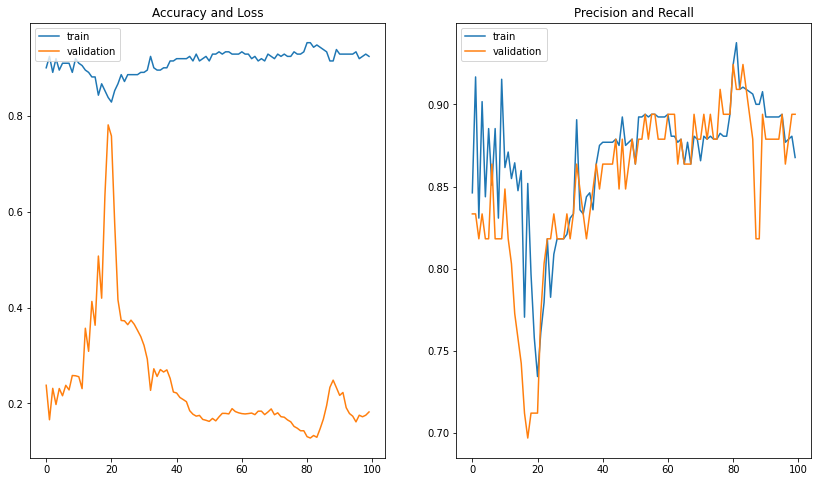

Confusion Matrix: 


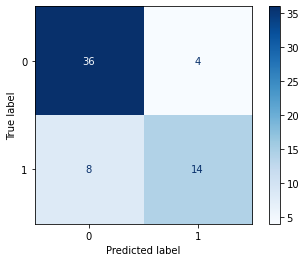

ROC: 


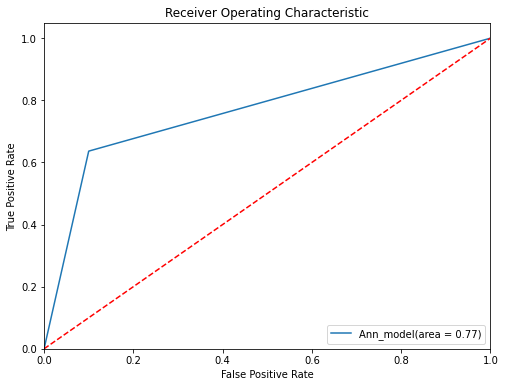

In [30]:
model.plot_result(y_test, y_pred, training_history)

In [31]:
model.save_model(model, 'models/spine_model_config_weights')

INFO:tensorflow:Assets written to: models/spine_model_config_weights\assets


In [32]:
model.save_model_as_json(model, 'models/spine_model_config')

In [33]:
model.save_weight(model, 'models/spine_weights')